## **Import**

In [2]:
import pandas as pd
import nltk
import re
import zipfile
import os
import shutil
import random
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Affichage des versions des bibliothèques installées
print(f"Pandas version: {pd.__version__}")
print(f"NLTK version: {nltk.__version__}")
print(f"re module: intégré à Python (pas de version spécifique)")
print(f"zipfile module: intégré à Python (pas de version spécifique)")
print(f"os module: intégré à Python (pas de version spécifique)")
print(f"shutil module: intégré à Python (pas de version spécifique)")
print(f"random module: intégré à Python (pas de version spécifique)")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version (TensorFlow backend): {tf.keras.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")

# Vérification des ressources NLTK
nltk.download('stopwords')
nltk.download('wordnet')
print(f"NLTK stopwords disponibles: {len(nltk.corpus.stopwords.words('english'))} mots")
lemmatizer = nltk.stem.WordNetLemmatizer()
print(f"Exemple de lemmatisation ('running' -> '{lemmatizer.lemmatize('running')}')")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Test des stopwords
stop_words = set(stopwords.words('english'))
print(f"Exemple de stopword : 'the' est-il un stopword ? {'the' in stop_words}")

# Test de la lemmatisation
lemmatizer = WordNetLemmatizer()
print(f"Lemmatization test: 'running' -> '{lemmatizer.lemmatize('running')}'")


# Vérification de Keras et des modules de traitement d'images
print(f"ImageDataGenerator disponible : {ImageDataGenerator is not None}")
print(f"ResNet50 disponible : {ResNet50 is not None}")
print(f"Model API disponible : {Model is not None}")
print(f"GlobalAveragePooling2D disponible : {GlobalAveragePooling2D is not None}")
print(f"preprocess_input disponible : {preprocess_input is not None}")


Pandas version: 2.2.2
NLTK version: 3.8.1
re module: intégré à Python (pas de version spécifique)
zipfile module: intégré à Python (pas de version spécifique)
os module: intégré à Python (pas de version spécifique)
shutil module: intégré à Python (pas de version spécifique)
random module: intégré à Python (pas de version spécifique)
TensorFlow version: 2.18.0
Keras version (TensorFlow backend): 3.8.0
Matplotlib version: 3.8.4


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


NLTK stopwords disponibles: 179 mots
Exemple de lemmatisation ('running' -> 'running')
Exemple de stopword : 'the' est-il un stopword ? True
Lemmatization test: 'running' -> 'running'
ImageDataGenerator disponible : True
ResNet50 disponible : True
Model API disponible : True
GlobalAveragePooling2D disponible : True
preprocess_input disponible : True


## **Classification supervisée d'images**

Dans un premier temps nous allons à nouveau charger les fichiers précédents.

In [5]:
# Télécharger les ressources nécessaires
nltk.download('stopwords')  
nltk.download('wordnet')    

# Charger les stopwords et initialiser le lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Fonction de prétraitement des textes
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  
    tokens = text.split()  
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Charger le fichier CSV
csv_path = "flipkart_com-ecommerce_sample_1050.csv"
df = pd.read_csv(csv_path)

# Afficher les 5 premières lignes
print(df.head())

                            uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed Ki

In [7]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [8]:
# Extraire la catégorie principale
df['category'] = df['product_category_tree'].str.extract(r'\["([^>]+)')

# Vérifier les premières catégories extraites
print(df['category'].head())

0    Home Furnishing 
1          Baby Care 
2          Baby Care 
3    Home Furnishing 
4    Home Furnishing 
Name: category, dtype: object


In [9]:
# Chemin vers le fichier ZIP
zip_path = "C:/Users/guill/OpenClassroom/Projet 6/Images - Copie.zip"
extract_to = "./Images" 

# Extraction
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Fichiers extraits dans : {extract_to}")

Fichiers extraits dans : ./Images


In [10]:
# Lister les fichiers extraits
extracted_files = os.listdir("./Images")
print(f"Nombre de fichiers extraits : {len(extracted_files)}")
print(f"Quelques fichiers : {extracted_files[:5]}")

Nombre de fichiers extraits : 1
Quelques fichiers : ['Images - Copie']


In [11]:
# Chemin vers le sous-dossier
subfolder_path = "./Images/Images - Copie"

# Lister les fichiers dans le sous-dossier
if os.path.exists(subfolder_path):
    files_in_subfolder = os.listdir(subfolder_path)
    print(f"Nombre de fichiers dans le sous-dossier : {len(files_in_subfolder)}")
    print(f"Quelques fichiers : {files_in_subfolder[:5]}")
else:
    print("Le sous-dossier n'existe pas. Vérifie le chemin.")

Nombre de fichiers dans le sous-dossier : 1053
Quelques fichiers : ['009099b1f6e1e8f893ec29a7023153c4.jpg', '0096e89cc25a8b96fb9808716406fe94.jpg', '00cbbc837d340fa163d11e169fbdb952.jpg', '00d84a518e0550612fcfcba3b02b6255.jpg', '00e966a5049a262cfc72e6bbf68b80e7.jpg']


In [12]:
# Définition du chemin du dataset
dataset_path = "./Images/Images - Copie"

# Liste des images
expected_images = set(df["image"].dropna())

# Liste des images réellement présentes
real_images = set(f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png')))

# Vérification des différences
missing_images = expected_images - real_images
extra_images = real_images - expected_images

print(f"Images réellement présentes : {len(real_images)} / {len(expected_images)}")
print(f"Images manquantes : {len(missing_images)}")
print(f"Images en trop : {len(extra_images)}")
print("Exemples d'images manquantes :", list(missing_images)[:5])
print("Exemples d'images en trop :", list(extra_images)[:5])

Images réellement présentes : 1050 / 1050
Images manquantes : 0
Images en trop : 0
Exemples d'images manquantes : []
Exemples d'images en trop : []


In [13]:
# Lister toutes les images disponibles
all_images = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

print(f"Nombre total d'images dans `{dataset_path}` : {len(all_images)}")
print("Exemples d'images :", all_images[:5])

Nombre total d'images dans `./Images/Images - Copie` : 1050
Exemples d'images : ['009099b1f6e1e8f893ec29a7023153c4.jpg', '0096e89cc25a8b96fb9808716406fe94.jpg', '00cbbc837d340fa163d11e169fbdb952.jpg', '00d84a518e0550612fcfcba3b02b6255.jpg', '00e966a5049a262cfc72e6bbf68b80e7.jpg']


Maintenant que tout est bon, commençons à diviser notre jeu de données en 2 parties. La première sera la phase train et la deuxième la phase test.

In [15]:
# Définition des chemins pour train/ et test/
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

# Création des dossiers s'ils n'existent pas encore
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

print("Dossiers `train/` et `test/` créés (ou déjà existants).")

Dossiers `train/` et `test/` créés (ou déjà existants).


In [27]:
# Lister toutes les images disponibles dans le dossier principal
all_images = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Vérifier que des images sont bien détectées
print(f"Nombre total d'images trouvées : {len(all_images)}")

# Mélanger les images pour une répartition aléatoire
random.shuffle(all_images)

# Définir le ratio train/test (75% - 25%)
split_index = int(len(all_images) * 0.75)
train_images = all_images[:split_index]
test_images = all_images[split_index:]

# Déplacer les fichiers dans train/ et test/
for img in train_images:
    shutil.move(os.path.join(dataset_path, img), os.path.join(train_path, img))

for img in test_images:
    shutil.move(os.path.join(dataset_path, img), os.path.join(test_path, img))

print(f"{len(train_images)} images déplacées vers `train/`")
print(f"{len(test_images)} images déplacées vers `test/`")


Nombre total d'images trouvées : 1050
787 images déplacées vers `train/`
263 images déplacées vers `test/`


Les images ont été correctement déplacés. Essayons à présent de les regrouper dans leur catégories associées

In [25]:
# Vérification des chemins
if not os.path.exists(train_path) or not os.path.exists(test_path):
    print("Erreur : Les dossiers `train/` et `test/` doivent exister avant de lancer cette étape.")
else:
    # Réorganisation des images selon les catégories
    for _, row in df.iterrows():
        image_name = row["image"]
        category = row["category"].strip()  # Supprime les espaces éventuels

        # Définir les chemins de destination
        category_train_path = os.path.join(train_path, category)
        category_test_path = os.path.join(test_path, category)

        # Créer les dossiers pour chaque catégorie s'ils n'existent pas
        os.makedirs(category_train_path, exist_ok=True)
        os.makedirs(category_test_path, exist_ok=True)

        # Déterminer si l'image est dans train ou test
        image_source = os.path.join(train_path, image_name) if os.path.exists(os.path.join(train_path, image_name)) 
        else os.path.join(test_path, image_name)

        # Vérifier si l'image existe avant de la déplacer
        if os.path.exists(image_source):
            dest_path = category_train_path if image_source.startswith(train_path) else category_test_path
            shutil.move(image_source, os.path.join(dest_path, image_name))

    print("Réorganisation terminée : les images sont classées par catégories.")

# Vérification des catégories créées
print("Catégories trouvées dans train :", os.listdir(train_path))
print("Catégories trouvées dans test :", os.listdir(test_path))

Réorganisation terminée : les images sont classées par catégories.
Catégories trouvées dans train : ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']
Catégories trouvées dans test : ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


In [29]:
for category in os.listdir(train_path):
    category_path = os.path.join(train_path, category)
    print(f"{category} : {len(os.listdir(category_path))} images")

Baby Care : 150 images
Beauty and Personal Care : 150 images
Computers : 150 images
Home Decor & Festive Needs : 150 images
Home Furnishing : 150 images
Kitchen & Dining : 150 images
Watches : 149 images


Très bien. On peut à présent commencer la data augmentation. On appliquera une normalisation, une rotation, on retournera l'image, on séparera 25 % des images pour la validation sans transformation et enfin on déplacera l’image horizontalement ou verticalement jusqu'à 20 % de sa taille.

In [31]:
# Normalisation des images avec Data Augmentation pour l'entraînement
datagen_train = ImageDataGenerator(
    rescale=1./255,  # Normalisation des pixels entre 0 et 1
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25  
)

# Générateur pour l'entraînement
train_generator = datagen_train.flow_from_directory(
    train_path,
    target_size=(256, 256),  
    batch_size=32,  
    class_mode='categorical',  
    subset='training'
)

# Générateur pour la validation
val_generator = datagen_train.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Générateur pour les tests
datagen_test = ImageDataGenerator(rescale=1./255)

test_generator = datagen_test.flow_from_directory(
    test_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Chargement des images terminé.")

Found 790 images belonging to 7 classes.
Found 259 images belonging to 7 classes.
Found 966 images belonging to 7 classes.
Chargement des images terminé.


Nous allons à présent utiliser le modèle pré-entraîné ResNet50 qui va ajouter des couches personnalisées pour classifier en 7 catégories.

In [33]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Gèle les poids du modèle pré-entraîné

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [35]:
# Création du DataGenerator avec augmentation de données pour l'entraînement
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input
)

# Génération des flux de données
train_flow = datagen_train.flow_from_directory(
    directory="./Images/Images - Copie/train",
    target_size=(256, 256),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_flow = datagen_train.flow_from_directory(
    directory="./Images/Images - Copie/train",
    target_size=(256, 256),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)


Found 790 images belonging to 7 classes.
Found 259 images belonging to 7 classes.


In [37]:
print("Vérification des objets :")
print("train_flow :", 'Défini' if 'train_flow' in locals() else 'Non défini')
print("val_flow :", 'Défini' if 'val_flow' in locals() else 'Non défini')

Vérification des objets :
train_flow : Défini
val_flow : Défini


In [39]:
# Charger ResNet50 sans la couche de classification
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Geler les poids du modèle pré-entraîné
base_model.trainable = False

# Récupérer le nombre de classes automatiquement depuis le générateur
num_classes = train_flow.num_classes  

# Ajouter des couches personnalisées avec Dropout
x = GlobalAveragePooling2D()(base_model.output)  
x = Dropout(0.5)(x)  # Réduit le sur-apprentissage
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Encore un Dropout
outputs = Dense(num_classes, activation='softmax')(x)  # Couche de sortie avec le bon nombre de classes

# Définir le modèle final
model = Model(inputs=base_model.input, outputs=outputs)

# Compilation du modèle
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# EarlyStopping pour stopper l'entraînement si la validation n'améliore plus
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Entraînement du modèle
history = model.fit(
    train_flow, 
    validation_data=val_flow, 
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


C:\Users\guill\OneDrive\Documents\OpenClassroom\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
24/25 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.1592 - loss: 3.1494

C:\Users\guill\OneDrive\Documents\OpenClassroom\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.1630 - loss: 3.1223 - val_accuracy: 0.4595 - val_loss: 1.5539
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.3308 - loss: 2.1615 - val_accuracy: 0.6448 - val_loss: 1.1412
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.4224 - loss: 1.7488 - val_accuracy: 0.7452 - val_loss: 0.9502
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.5232 - loss: 1.4205 - val_accuracy: 0.7568 - val_loss: 0.8644
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.5528 - loss: 1.3514 - val_accuracy: 0.7876 - val_loss: 0.7836
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5826 - loss: 1.2039 - val_accuracy: 0.7799 - val_loss: 0.7641
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.6471 - loss: 1.0938 - val_accuracy: 0.8069 - val_loss: 0.7154
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.6726 - loss: 0.9631 - val_accuracy: 0.8031 - val_loss: 0.6695
Ep

In [45]:
# Création du data generator pour le test 
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)

# Création de test_flow
test_flow = datagen_test.flow_from_directory(
    directory="./Images/Images - Copie/test",
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("test_flow créé avec succès.")

Found 966 images belonging to 7 classes.
test_flow créé avec succès.


In [41]:
test_loss, test_acc = model.evaluate(test_flow, verbose=1)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8282 - loss: 0.5368
Test Accuracy: 0.8768
Test Loss: 0.3960


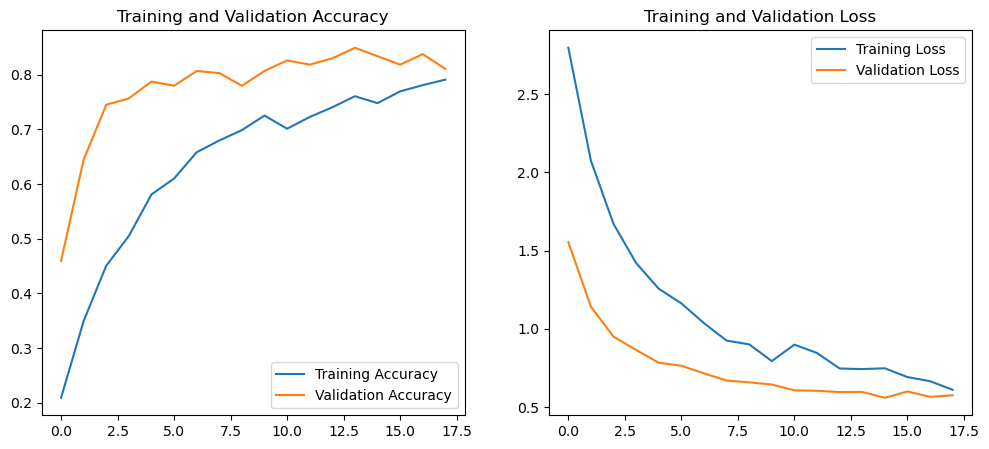

In [42]:
# Récupération des métriques d'entraînement
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Création des courbes
plt.figure(figsize=(12, 5))

# Courbe d'exactitude
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Ces graphiques montrent l'évolution de l'accuracy (précision) et de la loss (perte) pendant l'entraînement.

Accuracy :

    L'accuracy en entraînement (bleu) augmente progressivement et atteint environ 80 %.
    L'accuracy en validation (orange) commence plus haut (~50 %), progresse rapidement et atteint environ 85 %.
    La validation est légèrement au-dessus de l'entraînement, ce qui est inhabituel mais peut arriver si :
        - Le modèle généralise bien (aucun overfitting).
        - L'augmentation de données (ImageDataGenerator) introduit plus de complexité en entraînement.
        - La validation contient des images plus "faciles" que l'entraînement.

Conclusion accuracy :

    Pas de sur-apprentissage évident (les courbes restent proches).
    Le modèle continue d'apprendre après plusieurs époques.
    Léger écart en faveur de la validation, ce qui est un bon signe de généralisation.

Loss :

    La perte en entraînement (bleu) diminue régulièrement.
    La perte en validation (orange) suit une tendance similaire, puis se stabilise autour de 0.5.
    Pas de remontée soudaine de la validation loss, ce qui montre que le modèle ne sur-apprend pas.

Conclusion loss :

    Le modèle apprend bien et converge correctement.
    Pas de signe de sur-apprentissage, car la perte en validation ne remonte pas.

## **Conclusion**

Le modèle a bien appris à distinguer les classes d'images.

    - L'accuracy en validation est proche de l'accuracy en entraînement (~80-85%), ce qui montre qu'il généralise bien sur des images non vues.
    - La perte en validation diminue et se stabilise, preuve que le modèle ne sur-apprend pas et reste robuste.

Conclusion :

    - Oui, le modèle de classification supervisée fonctionne et est bien entraîné.
    - Il est capable de prédire correctement les classes sur des images inconnues.